In [2]:
from google.colab import drive
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm


In [3]:

drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Assignment_Data/'

Mounted at /content/drive


In [4]:
def load_images(path):
    images, labels = [], []
    for label in ['First Print', 'Second Print']:
        class_path = os.path.join(path, label)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))  # Resize for consistency
            images.append(img)
            labels.append(0 if label == 'First Print' else 1)
    return np.array(images), np.array(labels)

In [6]:
X, y = load_images(dataset_path)
X = X / 255.0  # Normalize pixel values
X = X.reshape(-1, 128, 128, 1)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
def extract_features(images):
    features = []
    for img in images:
        img_uint8 = (img * 255).astype("uint8")  # Convert float32 back to uint8
        hist = cv2.calcHist([img_uint8], [0], None, [256], [0, 256])
        features.append(hist.flatten())
    return np.array(features)


In [9]:
X_train_feat = extract_features(X_train.squeeze())
X_test_feat = extract_features(X_test.squeeze())


In [10]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5111 - loss: 2.4390 - val_accuracy: 0.4750 - val_loss: 0.8739
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 796ms/step - accuracy: 0.5203 - loss: 0.9367 - val_accuracy: 0.6000 - val_loss: 0.6235
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6019 - loss: 0.6391 - val_accuracy: 0.5250 - val_loss: 0.6254
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 894ms/step - accuracy: 0.6288 - loss: 0.5597 - val_accuracy: 0.9000 - val_loss: 0.4537
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 764ms/step - accuracy: 0.8750 - loss: 0.4010 - val_accuracy: 0.9000 - val_loss: 0.3409
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9094 - loss: 0.2798 - val_accuracy: 0.8750 - val_loss: 0.2866
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 809ms/step - accuracy: 0.9397 - loss: 0.1986 - val_accuracy: 0.9000 - val_loss: 0.2412
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9628 - loss: 0.1577 - val_accuracy: 0.9250 - val_loss: 0.2121
Epoc

In [11]:
y_pred_cnn = (model.predict(X_test) > 0.5).astype("int32").flatten()
print("CNN Model Performance:\n", classification_report(y_test, y_pred_cnn))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
CNN Model Performance:
               precision    recall  f1-score   support

           0       1.00      0.81      0.89        21
           1       0.83      1.00      0.90        19

    accuracy                           0.90        40
   macro avg       0.91      0.90      0.90        40
weighted avg       0.92      0.90      0.90        40



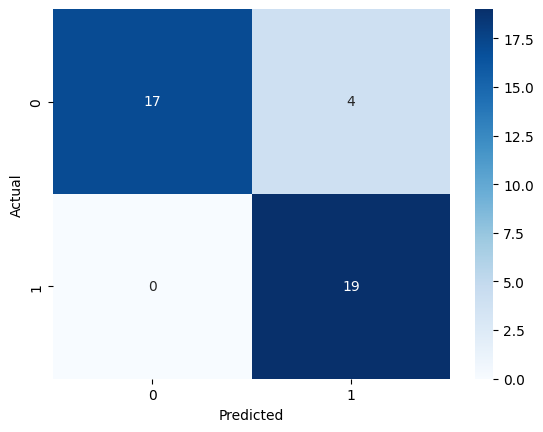

In [12]:
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


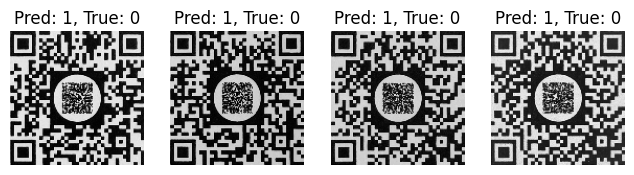

In [13]:
misclassified_indices = np.where(y_test != y_pred_cnn)[0]
plt.figure(figsize=(10, 5))
for i, idx in enumerate(misclassified_indices[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[idx].squeeze(), cmap='gray')
    plt.title(f"Pred: {y_pred_cnn[idx]}, True: {y_test[idx]}")
    plt.axis('off')
plt.show()

In [14]:
!pip install pyzbar
!apt-get install libzbar0



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libzbar0 is already the newest version (0.23.92-4build2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [16]:
from google.colab import files  # Import the 'files' object from google.colab

def predict_image():
    uploaded = files.upload()
    for fn in uploaded.keys():
        img = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
        if img is None:
          print(f"Error: Could not read image file: {fn}")
          return
        img = cv2.resize(img, (128, 128))
        img = img / 255.0
        img = img.reshape(-1, 128, 128, 1)
        prediction = model.predict(img)
        predicted_class = (prediction > 0.5).astype("int32").flatten()[0]
        print(f"Prediction for {fn}: {predicted_class} (0: First Print, 1: Second Print)")

predict_image()

Saving pngimg.com - qr_code_PNG10.png to pngimg.com - qr_code_PNG10 (3).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction for pngimg.com - qr_code_PNG10 (3).png: 1 (0: First Print, 1: Second Print)
